**TASK: IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [76]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA

Read in the data set "Miles_Traveled.csv" from the Data folder. Figure out how to set the date to a datetime index columns

In [77]:
df = pd.read_csv('../Data/Miles_Traveled.csv',
                 index_col='DATE',parse_dates=True)
                                                 
df.index.freq = 'MS'
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


**Task: Change the column names to Value**

In [78]:
df.columns = ['Value']
df.head()

,Value
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


**TASK: Plot out the time series**

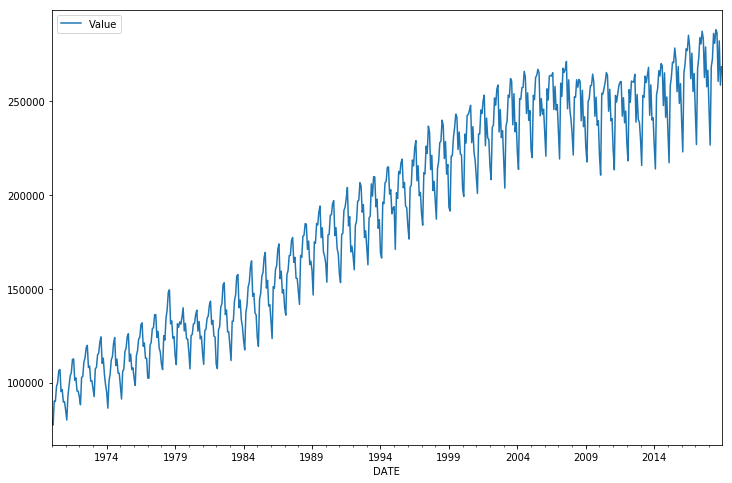

In [79]:
df.plot(figsize=(12,8));

**TASK: Perform a Seasonal Decomposition on the model and plot out the ETS components**

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Value'])

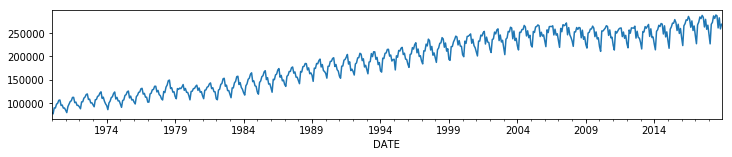

In [81]:
results.observed.plot(figsize=(12,2))

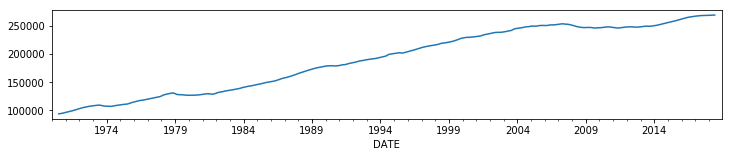

In [82]:
results.trend.plot(figsize=(12,2));

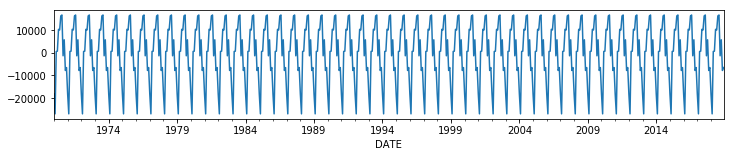

In [83]:
results.seasonal.plot(figsize=(12,2));

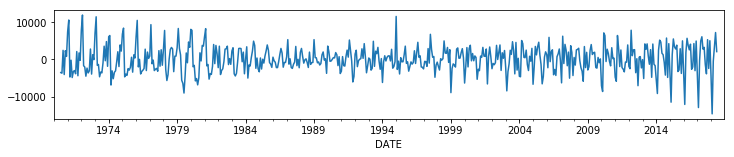

In [84]:
results.resid.plot(figsize=(12,2));

## Train Test Split

**TASK: Figure out the length of the data set**

In [85]:
len(df)

588

**TASK: Split the data into a train/test split where the test set is the last 12 months of data.**

In [86]:
588-12

576

In [87]:
train = df[:576]
test = df[576:]
len(train), len(test)

(576, 12)

## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [102]:
# (X - Xmin) / (Xmax - Xmin)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [103]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The n_input is up to you, but at a minimum it should be at least 12.**

In [104]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [105]:
# We can optimize n_input
n_input = 12

# Generally in time-series n_feature is 1 (1 column is used as y)
n_features = 1

generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train, 
                                length=n_input, batch_size=1)

### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTAM units you want and a final Dense Layer.**

In [106]:
# Sequential allows a bunch of layers to add in sequence
from keras.models import Sequential

# Dense connects all neurons 4m previous layer to next layer
from keras.layers import Dense

# Long short term memory
from keras.layers import LSTM

In [107]:
# define model
model = Sequential()

# 100 Neurons
model.add(LSTM(150, activation='relu', 
               input_shape=(n_input, n_features)))

# One final output of y, so only 1 neuron
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [108]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


**TASK: Fit the model to the generator (it should be a lot of epochs, but do as many as you have the patience for! :)**

In [109]:
# fit model
# 1 Epoch is an entire run through the training data
model.fit_generator(generator,epochs=50)

Epoch 1/50
564/564 [==============================] - 15s 27ms/step - loss: 0.0104
Epoch 2/50
564/564 [==============================] - 15s 27ms/step - loss: 0.0052
Epoch 3/50
564/564 [==============================] - 16s 28ms/step - loss: 0.0037
Epoch 4/50
564/564 [==============================] - 16s 29ms/step - loss: 0.0027
Epoch 5/50
564/564 [==============================] - 17s 29ms/step - loss: 0.0020
Epoch 6/50
564/564 [==============================] - 17s 30ms/step - loss: 0.0020
Epoch 7/50
564/564 [==============================] - 17s 30ms/step - loss: 0.0014
Epoch 8/50
564/564 [==============================] - 17s 30ms/step - loss: 0.0013
Epoch 9/50
564/564 [==============================] - 16s 29ms/step - loss: 0.0011
Epoch 10/50
564/564 [==============================] - 17s 29ms/step - loss: 0.0012
Epoch 11/50
564/564 [==============================] - 17s 30ms/step - loss: 8.4595e-04
Epoch 12/50
564/564 [==============================] - 17s 30ms/step - loss: 0.00

**TASK: Plot the history of the loss that occured during training.**

In [110]:
# What keys are stored in the trained model summary dictionary
model.history.history.keys()

dict_keys(['loss'])

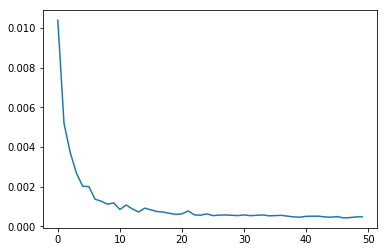

In [111]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

**TASK: Based on your test data and input size, create an appropriate;y sized "first evaluation batch" like we did in the lecture.**

In [112]:
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.79630397],
       [0.71226435],
       [0.90477416],
       [0.93121043],
       [0.98386382],
       [0.96757519],
       [1.        ],
       [0.9801859 ],
       [0.8824684 ],
       [0.95995255],
       [0.85883345],
       [0.90086755]])

**TASK: Generate predictions into the same time stamps as the test set**

In [113]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
first_eval_batch

array([[[0.79630397],
        [0.71226435],
        [0.90477416],
        [0.93121043],
        [0.98386382],
        [0.96757519],
        [1.        ],
        [0.9801859 ],
        [0.8824684 ],
        [0.95995255],
        [0.85883345],
        [0.90086755]]])

In [114]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))


# if we need to forecast for x number of months put `range(x)`
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead 
    #([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],
                              axis=1)

In [115]:
test_predictions

[array([0.8027797], dtype=float32),
 array([0.73051965], dtype=float32),
 array([0.89804506], dtype=float32),
 array([0.9284694], dtype=float32),
 array([0.98217046], dtype=float32),
 array([0.9670825], dtype=float32),
 array([0.9983072], dtype=float32),
 array([0.9767698], dtype=float32),
 array([0.8906828], dtype=float32),
 array([0.95507276], dtype=float32),
 array([0.8641871], dtype=float32),
 array([0.9007331], dtype=float32)]

## Inverse Transformations and Compare

**TASK: Inverse Transform your new forecasted predictions.**

In [116]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[245946.25646353],
       [230778.80555141],
       [265942.55677271],
       [272328.65961814],
       [283600.56227195],
       [280433.58392859],
       [286987.68548298],
       [282466.95882976],
       [264397.21386731],
       [277912.72751892],
       [258835.74096715],
       [266506.78121245]])

**TASK: Create a new dataframe that has both the original test values and your predictions for them.**

In [117]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions
test

/Users/sayantan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Value,Predictions
DATE,,
2018-01-01,245695.0,245946.256464
2018-02-01,226660.0,230778.805551
2018-03-01,268480.0,265942.556773
2018-04-01,272475.0,272328.659618
2018-05-01,286164.0,283600.562272
2018-06-01,280877.0,280433.583929
2018-07-01,288145.0,286987.685483
2018-08-01,286608.0,282466.958830
2018-09-01,260595.0,264397.213867


**TASK: Plot out the test set against your own predicted values.**

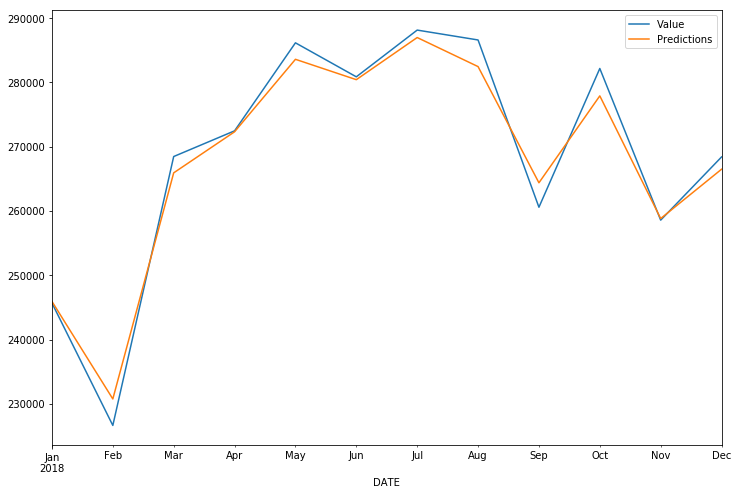

In [118]:
test.plot(figsize=(12,8))

# Saving Models

**TASK: Optional, Save your model!**

In [119]:
model.save('my_rnn_model2.h5')

In [120]:
# Load a model
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
